In [1]:
source("/secure/projects/HTAPP_MBC/src/init_phase2.R")
library(genefu,quietly = TRUE)
#source(file.path(metaDir,"mbc_signatures_ofir.R"))
library("ggalluvial")

Registered S3 method overwritten by 'R.oo':
  method        from       
  throw.default R.methodsS3
Loading combined annotation: annot
Package 'mclust' version 5.4.6
Type 'citation("mclust")' for citing this R package in publications.

Attaching package: 'e1071'

The following object is masked from 'package:gtools':

    permutations


Attaching package: 'BiocGenerics'

The following objects are masked from 'package:parallel':

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following object is masked from 'package:limma':

    plotMA

The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs

The following objects are masked from 'package:base':

    Filter, Find, Map, Position, Reduce, anyDuplicated, append,
    as.data.frame, basename, cbind, colnames, dirname, do.call,
    duplicated, eval, evalq, get, grep, grepl, intersect,

In [2]:
#get cell cycle genes
s.genes <- cc.genes$s.genes
g2m.genes <- cc.genes$g2m.genes

In [3]:
samples=c(unique(sample_sheet$sampleid))
samples=sort(grep("HTAPP-214-SMP-6753|SMP-iso",samples,invert = TRUE,value = TRUE))

In [4]:
out_dir=file.path(analysisDir,"00_subtypes")
dir.create(out_dir,recursive = TRUE)

Warning message in dir.create(out_dir, recursive = TRUE):
"'/scratch/projects/HTAPP_MBC//phase2/analysis//00_subtypes' already exists"

In [ ]:
#functions
get_profile=function(x){
    p=apply(dat[as.character(x), ], 2, mean)
    p_dt=data.table(genes=names(p),values=p)
    return(p_dt)
}

#run loop
for (sample in samples){

    print(sample)
    fp=file.path(out_dir,paste0(sample,"_subtypes.tsv"))
    
    if (file.exists(fp)){
        print("done!")
        next
    }
    
    simpleCache(cacheName = sample,cacheDir = cacheDir,cacheSubDir = "filtered",assignToVariable = "ss")
    nstart=nrow(ss@meta.data)
    
    #cell cycle (suppressing warnings of not finding genes. Checked several, that they are not simply different versions)
    suppressWarnings(ss <- CellCycleScoring(ss, s.features = s.genes, g2m.features = g2m.genes, search=TRUE))
    cell_cycle=as.data.table(ss@meta.data[,c("S.Score","G2M.Score","Phase"),],keep.rownames="cellid")

    
    #Ofir's cell type signatures (suppressing warnings of not finding genes. Checked several, that they are not simply different versions)
    #suppressWarnings(ss <- AddModuleScore(ss,features = mbc_signatures,name = names(mbc_signatures),search=TRUE))
    #colnames(ss@meta.data)[colnames(ss@meta.data)%in%paste0(names(mbc_signatures),1:length(names(mbc_signatures)))]=names(mbc_signatures)
    
    #pam50
    dat=t(GetAssayData(ss,slot = "data"))
    colnames(dat)[colnames(dat)=="NUF2"]="CDCA1"
    colnames(dat)[colnames(dat)=="NDC80"]="KNTC2"
    colnames(dat)[colnames(dat)=="ORC6"]="ORC6L"
    gene_annot=data.frame(Gene.Symbol=colnames(dat))
    
    #average data by cluster
    clusters=as.data.table(ss@meta.data[,c("RNA_snn_res.0.8"),drop=FALSE],keep.rownames="cellid")
    cluster_profiles=data.frame(dcast(clusters[,get_profile(cellid) , by = "RNA_snn_res.0.8"],RNA_snn_res.0.8~genes,value.var="values"),row.names = "RNA_snn_res.0.8")
    
    
    oldw <- getOption("warn")
    options(warn=-1)
    mst=molecular.subtyping(sbt.model="pam50",data=dat,annot = gene_annot)
    mst_cl=molecular.subtyping(sbt.model="pam50",data=cluster_profiles,annot = gene_annot)
    options(warn=oldw)
    mst_dt=as.data.table(mst$subtype.proba,keep.rownames = "cellid")
    mst_cl_dt=as.data.table(mst_cl$subtype.proba,keep.rownames = "RNA_snn_res.0.8")
    mst_cl_dt=merge(clusters,mst_cl_dt,by="RNA_snn_res.0.8")
    mst_cl_dt[,RNA_snn_res.0.8:=NULL,]
    mst_dt=rbindlist(list(mst_dt[,mode:="single",],mst_cl_dt[,mode:="cluster",]))
    
    mst_dt[,subtype:=c("Basal","Her2","LumA","LumB","Normal")[which.max(c(Basal,Her2,LumA,LumB,Normal))],by=1:nrow(mst_dt)]
    mst_dt[,subtype_prob:=max(c(Basal,Her2,LumA,LumB,Normal)),by=1:nrow(mst_dt)]
    mst_dt[,subtype_filt:=ifelse(subtype_prob<0.6|is.na(subtype_prob),"unknown",subtype),]

    mst_dt=merge(mst_dt[mode=="single"],mst_dt[mode=="cluster"],by="cellid",suffixes = c("_single","_cluster"))
    setnames(mst_dt,names(mst_dt),paste0("pam50_",names(mst_dt)))
    
    combined=merge(mst_dt,cell_cycle,by.x="pam50_cellid",by.y="cellid")
    nend=nrow(combined)
    stopifnot(nstart==nend)
    write.table(combined,fp,sep="\t",row.names=FALSE,quote=FALSE)
    
}

In [56]:
#collect all the data
res=data.table()
for (sample in samples){
    res=rbindlist(list(res,fread(file.path(out_dir,paste0(sample,"_subtypes.tsv")))))
}

In [58]:
write.table(res,file = paste0(out_dir,"/subtypes.tsv"),sep="\t",row.names = FALSE,quote=FALSE)

In [57]:
head(res)

pam50_cellid                                       pam50_Basal_single
1 HTAPP-211-SMP-6751-TST-channel1_AAACCCAAGAAATGGG-1  0                
2 HTAPP-211-SMP-6751-TST-channel1_AAACCCAAGCACTTTG-1 NA                
3 HTAPP-211-SMP-6751-TST-channel1_AAACCCAAGCTCCCTT-1  0                
4 HTAPP-211-SMP-6751-TST-channel1_AAACCCACACAGCTTA-1  0                
5 HTAPP-211-SMP-6751-TST-channel1_AAACCCACAGGGACTA-1  0                
6 HTAPP-211-SMP-6751-TST-channel1_AAACCCACATGACGTT-1  0                
  pam50_Her2_single pam50_LumA_single pam50_LumB_single pam50_Normal_single
1  0                0.32142857        0.000000000       0.6785714          
2 NA                        NA                 NA              NA          
3  0                0.01193317        0.000000000       0.9880668          
4  0                0.50000000        0.500000000       0.0000000          
5  0                0.70822575        0.001844338       0.2899299          
6  0                0.67441860        0.000000000       0.3255814          
  pam50_mode_single pam50_subtype_single pam50_subtype_prob_single
1 single            Normal               0.6785714                
2 single            NA                          NA                
3 single            Normal               0.9880668                
4 single            LumA                 0.5000000                
5 single            LumA                 0.7082257                
6 single            LumA                 0.6744186                
  pam50_subtype_filt_single pam50_Basal_cluster pam50_Her2_cluster
1 Normal                    0.1168433           0.450517175       
2 unknown                   0.0000000           0.009878761       
3 Normal                    0.0000000           0.388576026       
4 unknown                   0.0000000           0.211118930       
5 LumA                      0.0000000           0.009632224       
6 LumA                      0.0000000           0.009878761       
  pam50_LumA_cluster pam50_LumB_cluster pam50_Normal_cluster pam50_mode_cluster
1 0.0000000          0.4326395          0.00000000           cluster           
2 0.7557252          0.1139051          0.12049094           cluster           
3 0.3462591          0.2651649          0.00000000           cluster           
4 0.3246540          0.4642271          0.00000000           cluster           
5 0.7782837          0.1436077          0.06847636           cluster           
6 0.7557252          0.1139051          0.12049094           cluster           
  pam50_subtype_cluster pam50_subtype_prob_cluster pam50_subtype_filt_cluster
1 Her2                  0.4505172                  unknown                   
2 LumA                  0.7557252                  LumA                      
3 Her2                  0.3885760                  unknown                   
4 LumB                  0.4642271                  unknown                   
5 LumA                  0.7782837                  LumA                      
6 LumA                  0.7557252                  LumA                      
  S.Score     G2M.Score   Phase
1  0.16565963 -0.03490159 S    
2 -0.04257187 -0.05671602 G1   
3 -0.05553100 -0.04590945 G1   
4 -0.04088128 -0.05592033 G1   
5 -0.08220964 -0.07610006 G1   
6 -0.05446524 -0.06127165 G1

In [47]:
pl_pam50=list()
pl_pam50_sg=list()
pl_ct=list()
for (sample in sort(grep("HTAPP-214-SMP-6753|SMP-iso",samples,invert = TRUE,value = TRUE))[1:3]){
    print(sample)
    fp=file.path(out_dir,paste0(sample,"_subtypes.tsv"))
    simpleCache(sample,cacheDir = cacheDir,cacheSubDir = "filtered",assignToVariable = "so")
    md=data.frame(fread(fp),row.names = "pam50_cellid")
    so=AddMetaData(so,md)
    pl_pam50[[sample]]=UMAPPlot(so,group.by="pam50_subtypecluster")
    pl_pam50_sg[[sample]]=UMAPPlot(so,group.by="pam50_subtypesingle")
    pl_ct[[sample]]=UMAPPlot(so,group.by="labels_cl_unif")
}

[1] "HTAPP-211-SMP-6751"


::Loading cache::	/scratch/projects/HTAPP_MBC//phase2/RCache//filtered/HTAPP-211-SMP-6751.RData


[1] "HTAPP-213-SMP-6752"


::Loading cache::	/scratch/projects/HTAPP_MBC//phase2/RCache//filtered/HTAPP-213-SMP-6752.RData


[1] "HTAPP-223-SMP-6755"


::Loading cache::	/scratch/projects/HTAPP_MBC//phase2/RCache//filtered/HTAPP-223-SMP-6755.RData


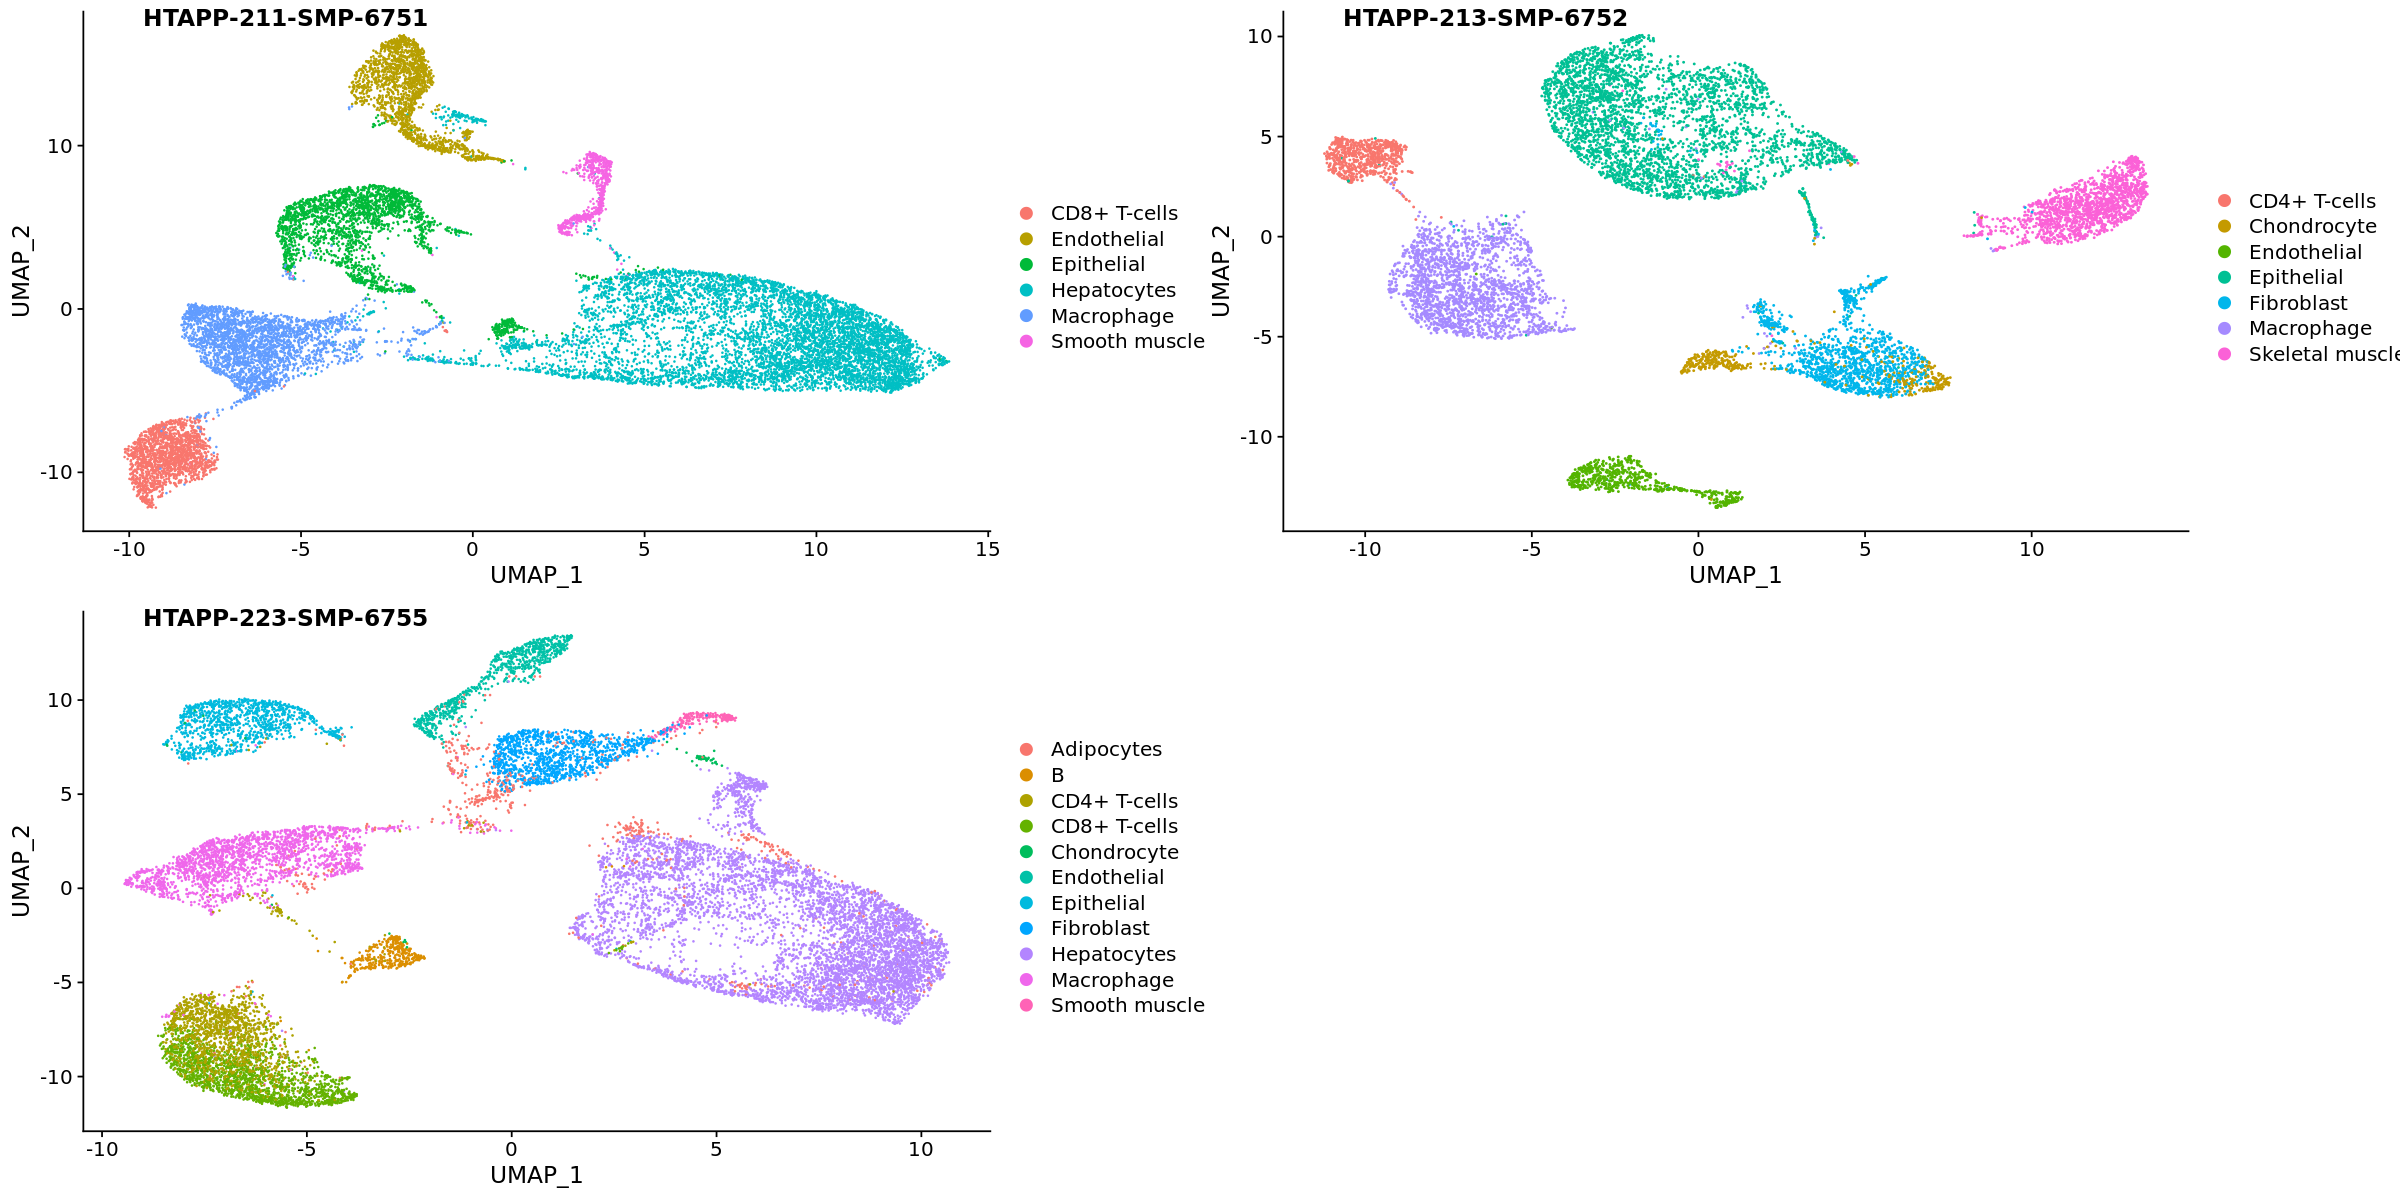

In [43]:
options(repr.plot.width = 20, repr.plot.height =10)
cowplot::plot_grid(plotlist = pl_ct,labels = names(pl_ct))

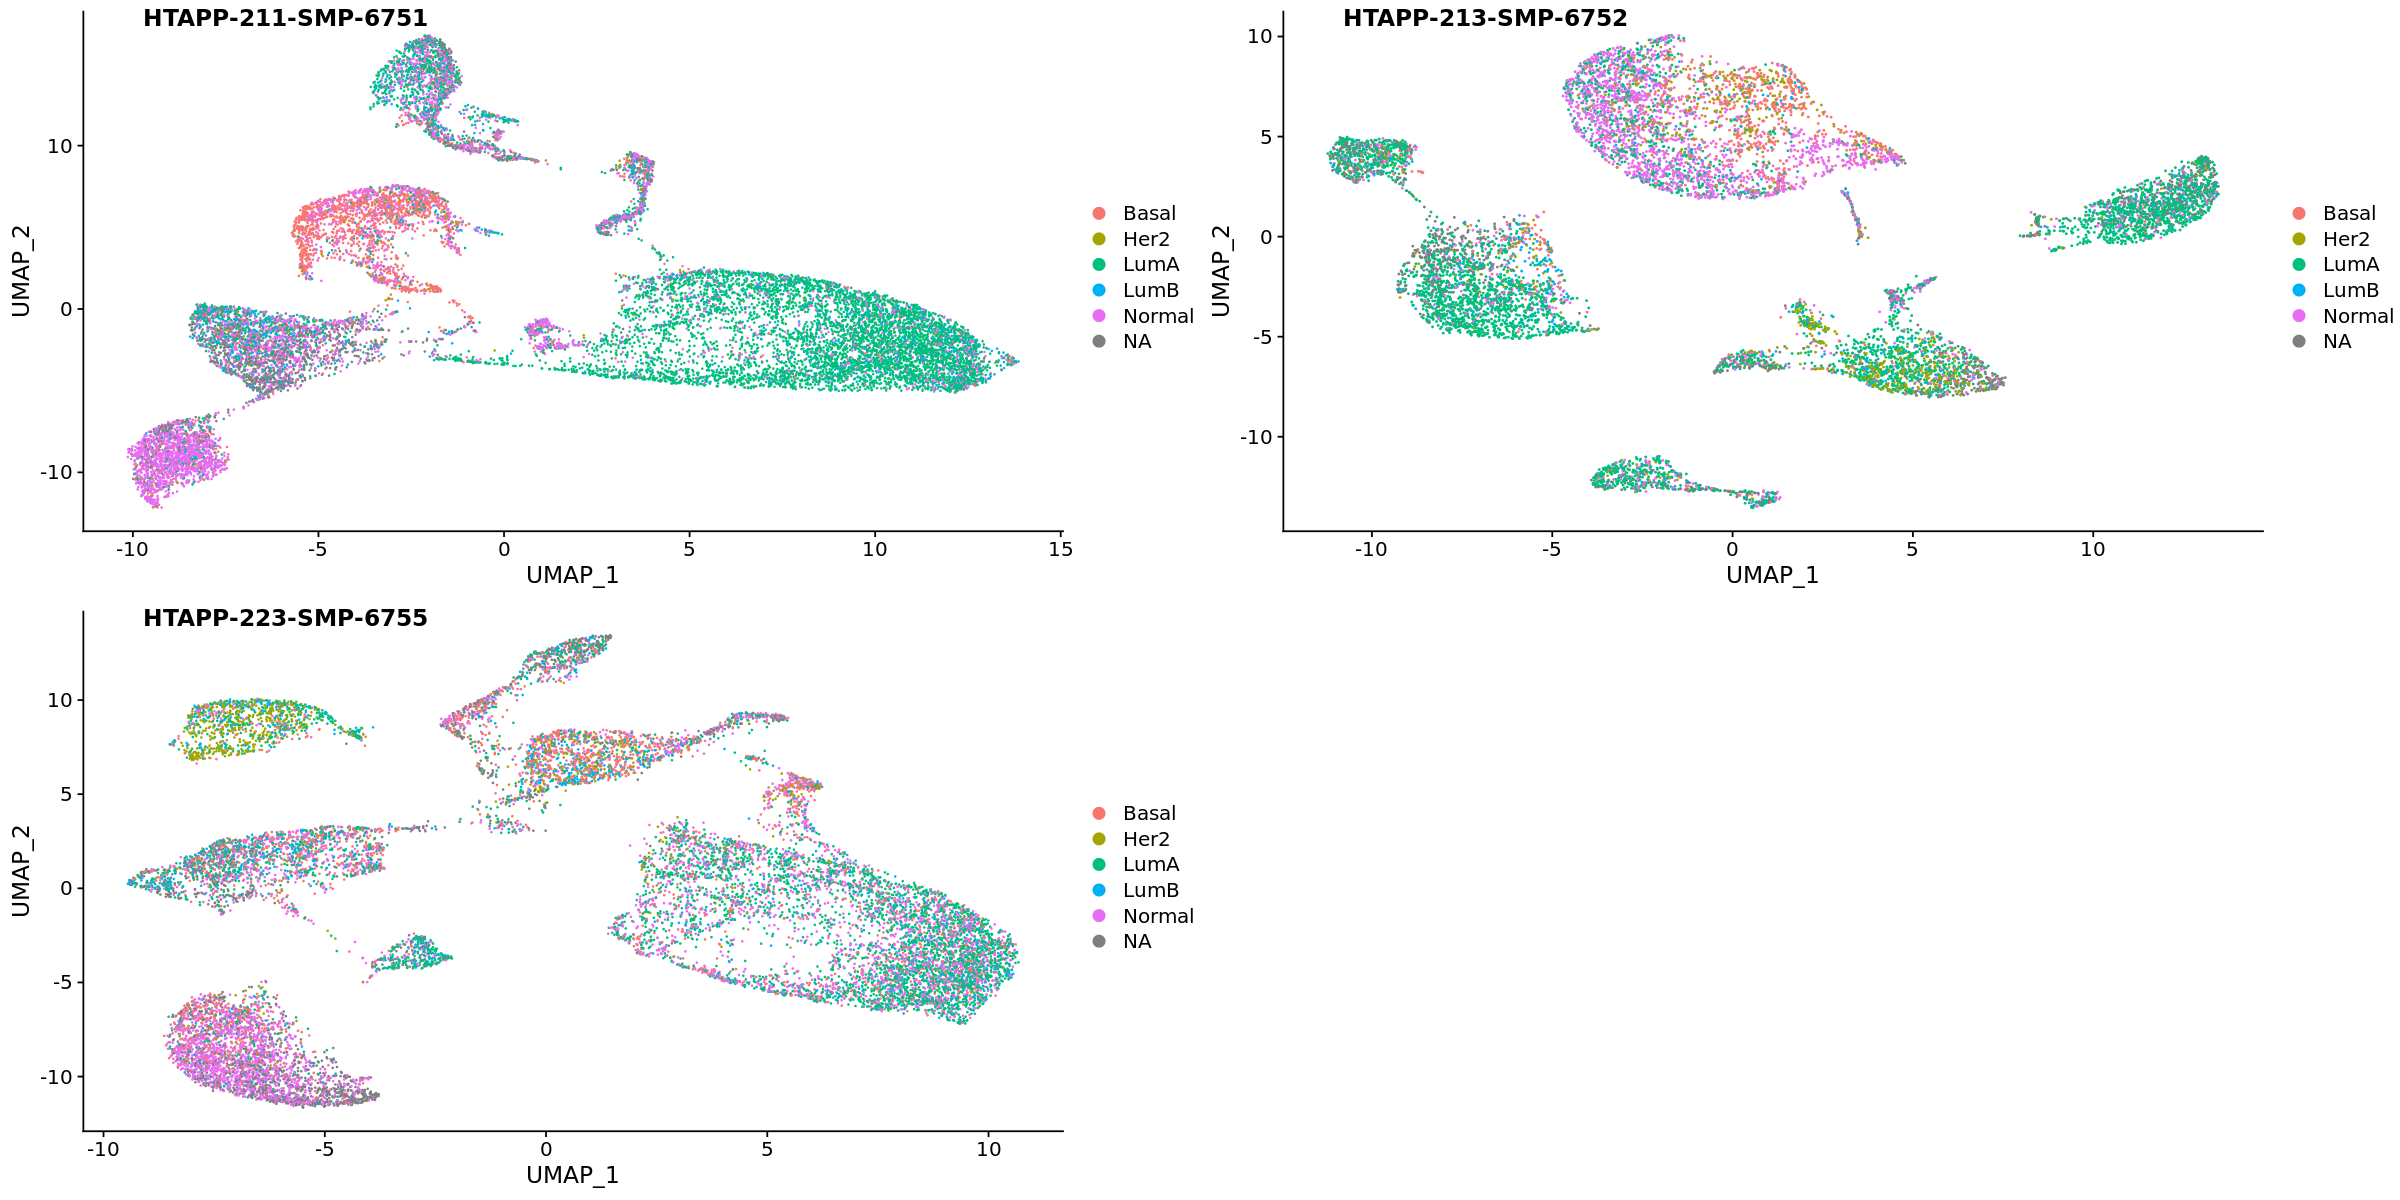

In [48]:
options(repr.plot.width = 20, repr.plot.height =10)
cowplot::plot_grid(plotlist = pl_pam50_sg,labels = names(pl_pam50_sg))

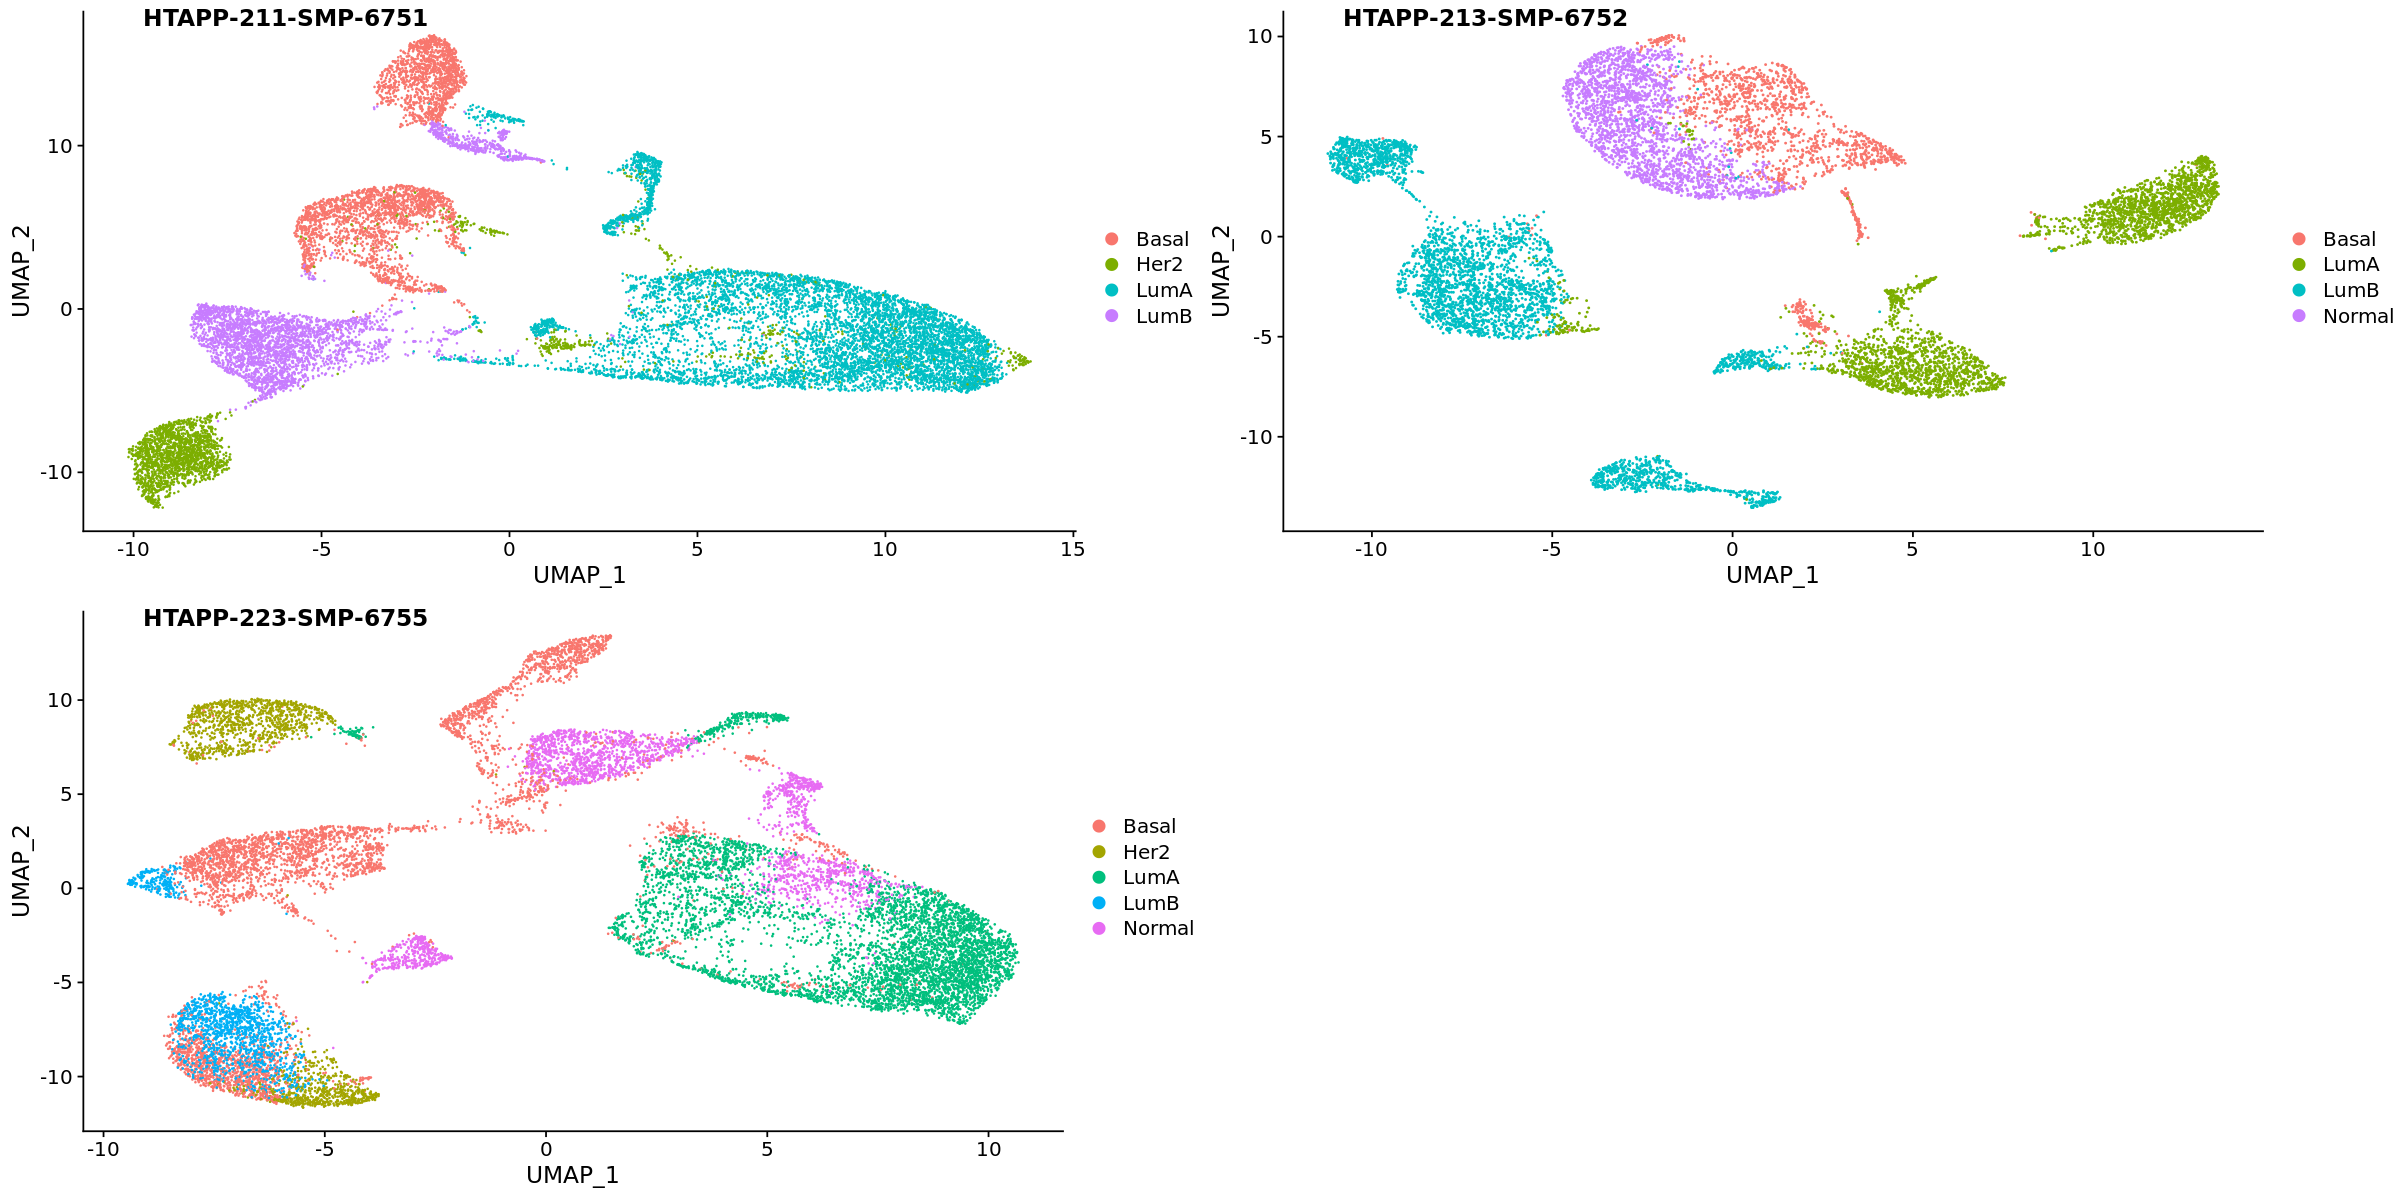

In [49]:
options(repr.plot.width = 20, repr.plot.height =10)
cowplot::plot_grid(plotlist = pl_pam50,labels = names(pl_pam50))

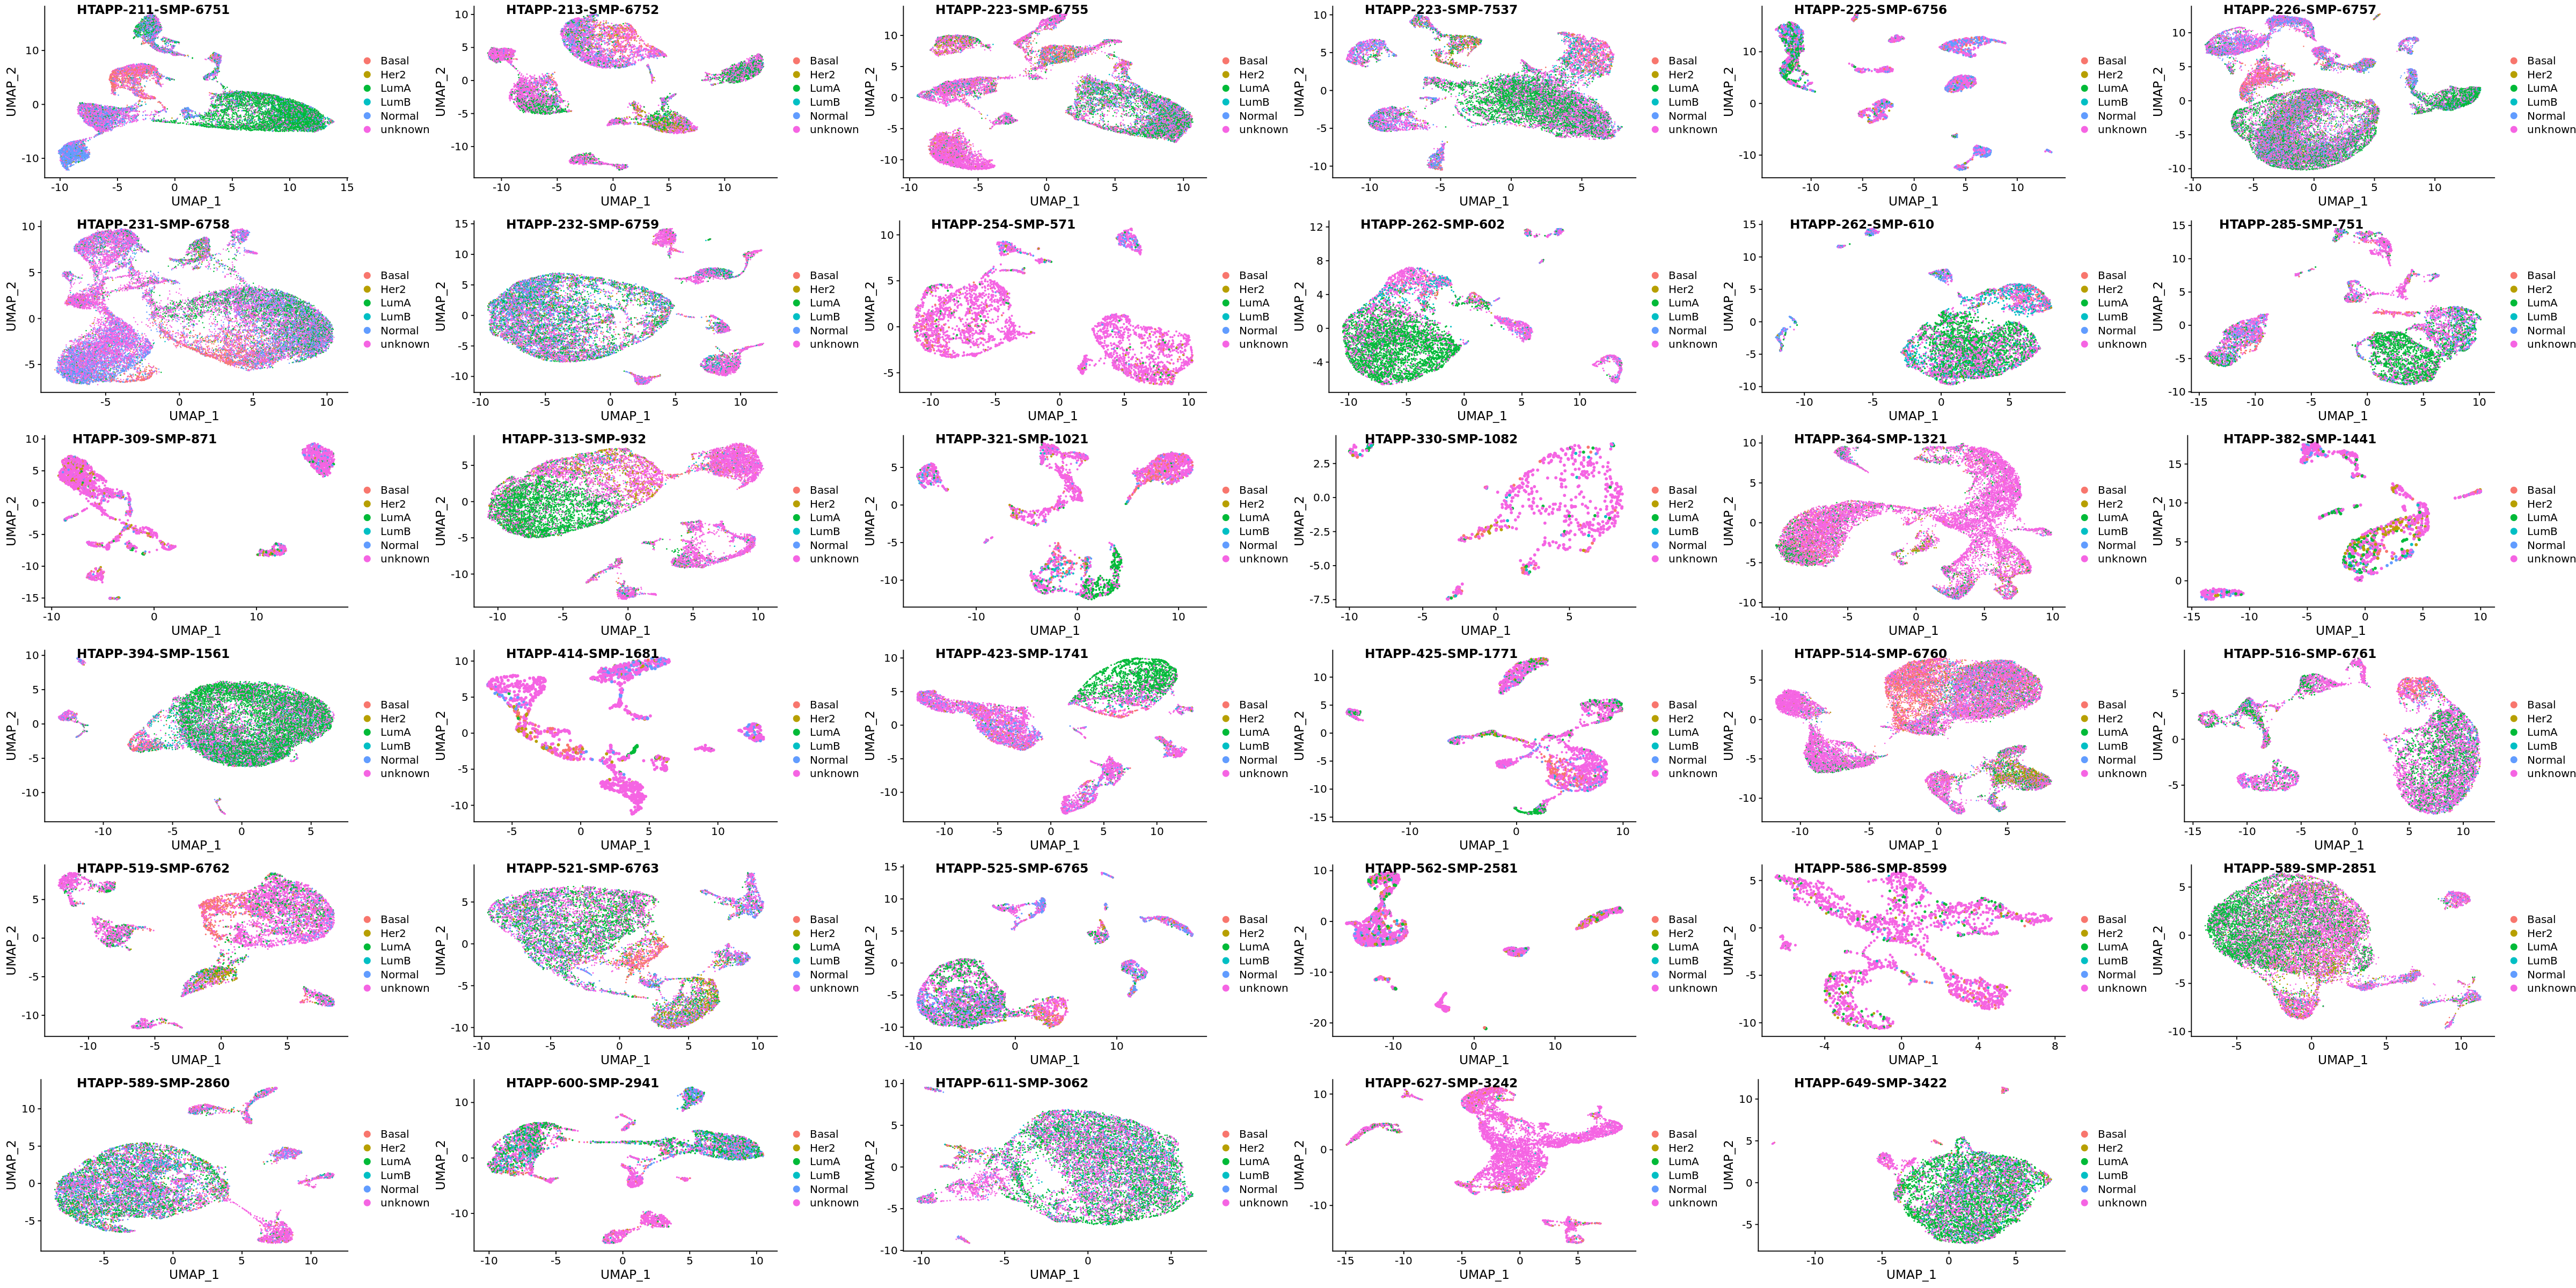

In [14]:
options(repr.plot.width = 40, repr.plot.height =20)
cowplot::plot_grid(plotlist = pl_pam50,labels = names(pl_pam50))

In [18]:
pl_alluvial=list()
for (sample in sort(grep("HTAPP-214-SMP-6753|SMP-iso",samples,invert = TRUE,value = TRUE))[1:3]){
    print(sample)
    fp=file.path(out_dir,paste0(sample,"_subtypes.tsv"))
    md=fread(fp)
    md_red=md[,.N,by=c("subtype_filt","labels_cl_unif","Phase")]
    
   sub_pl= ggplot(md_red,
       aes(y = N, axis1 = labels_cl_unif, axis2 = subtype_filt, axis3 = Phase)) +
  geom_alluvium(aes(fill = labels_cl_unif), width = 1/12) +
  geom_stratum(width = 1/12, fill = "black", color = "grey") +
  geom_label(stat = "stratum", infer.label = TRUE) +
  scale_x_discrete(limits = c("Cell types", "pam50","Cell cycle"), expand = c(.05, .05))

    pl_alluvial[[sample]]=sub_pl
}

[1] "HTAPP-211-SMP-6751"
[1] "HTAPP-213-SMP-6752"
[1] "HTAPP-223-SMP-6755"


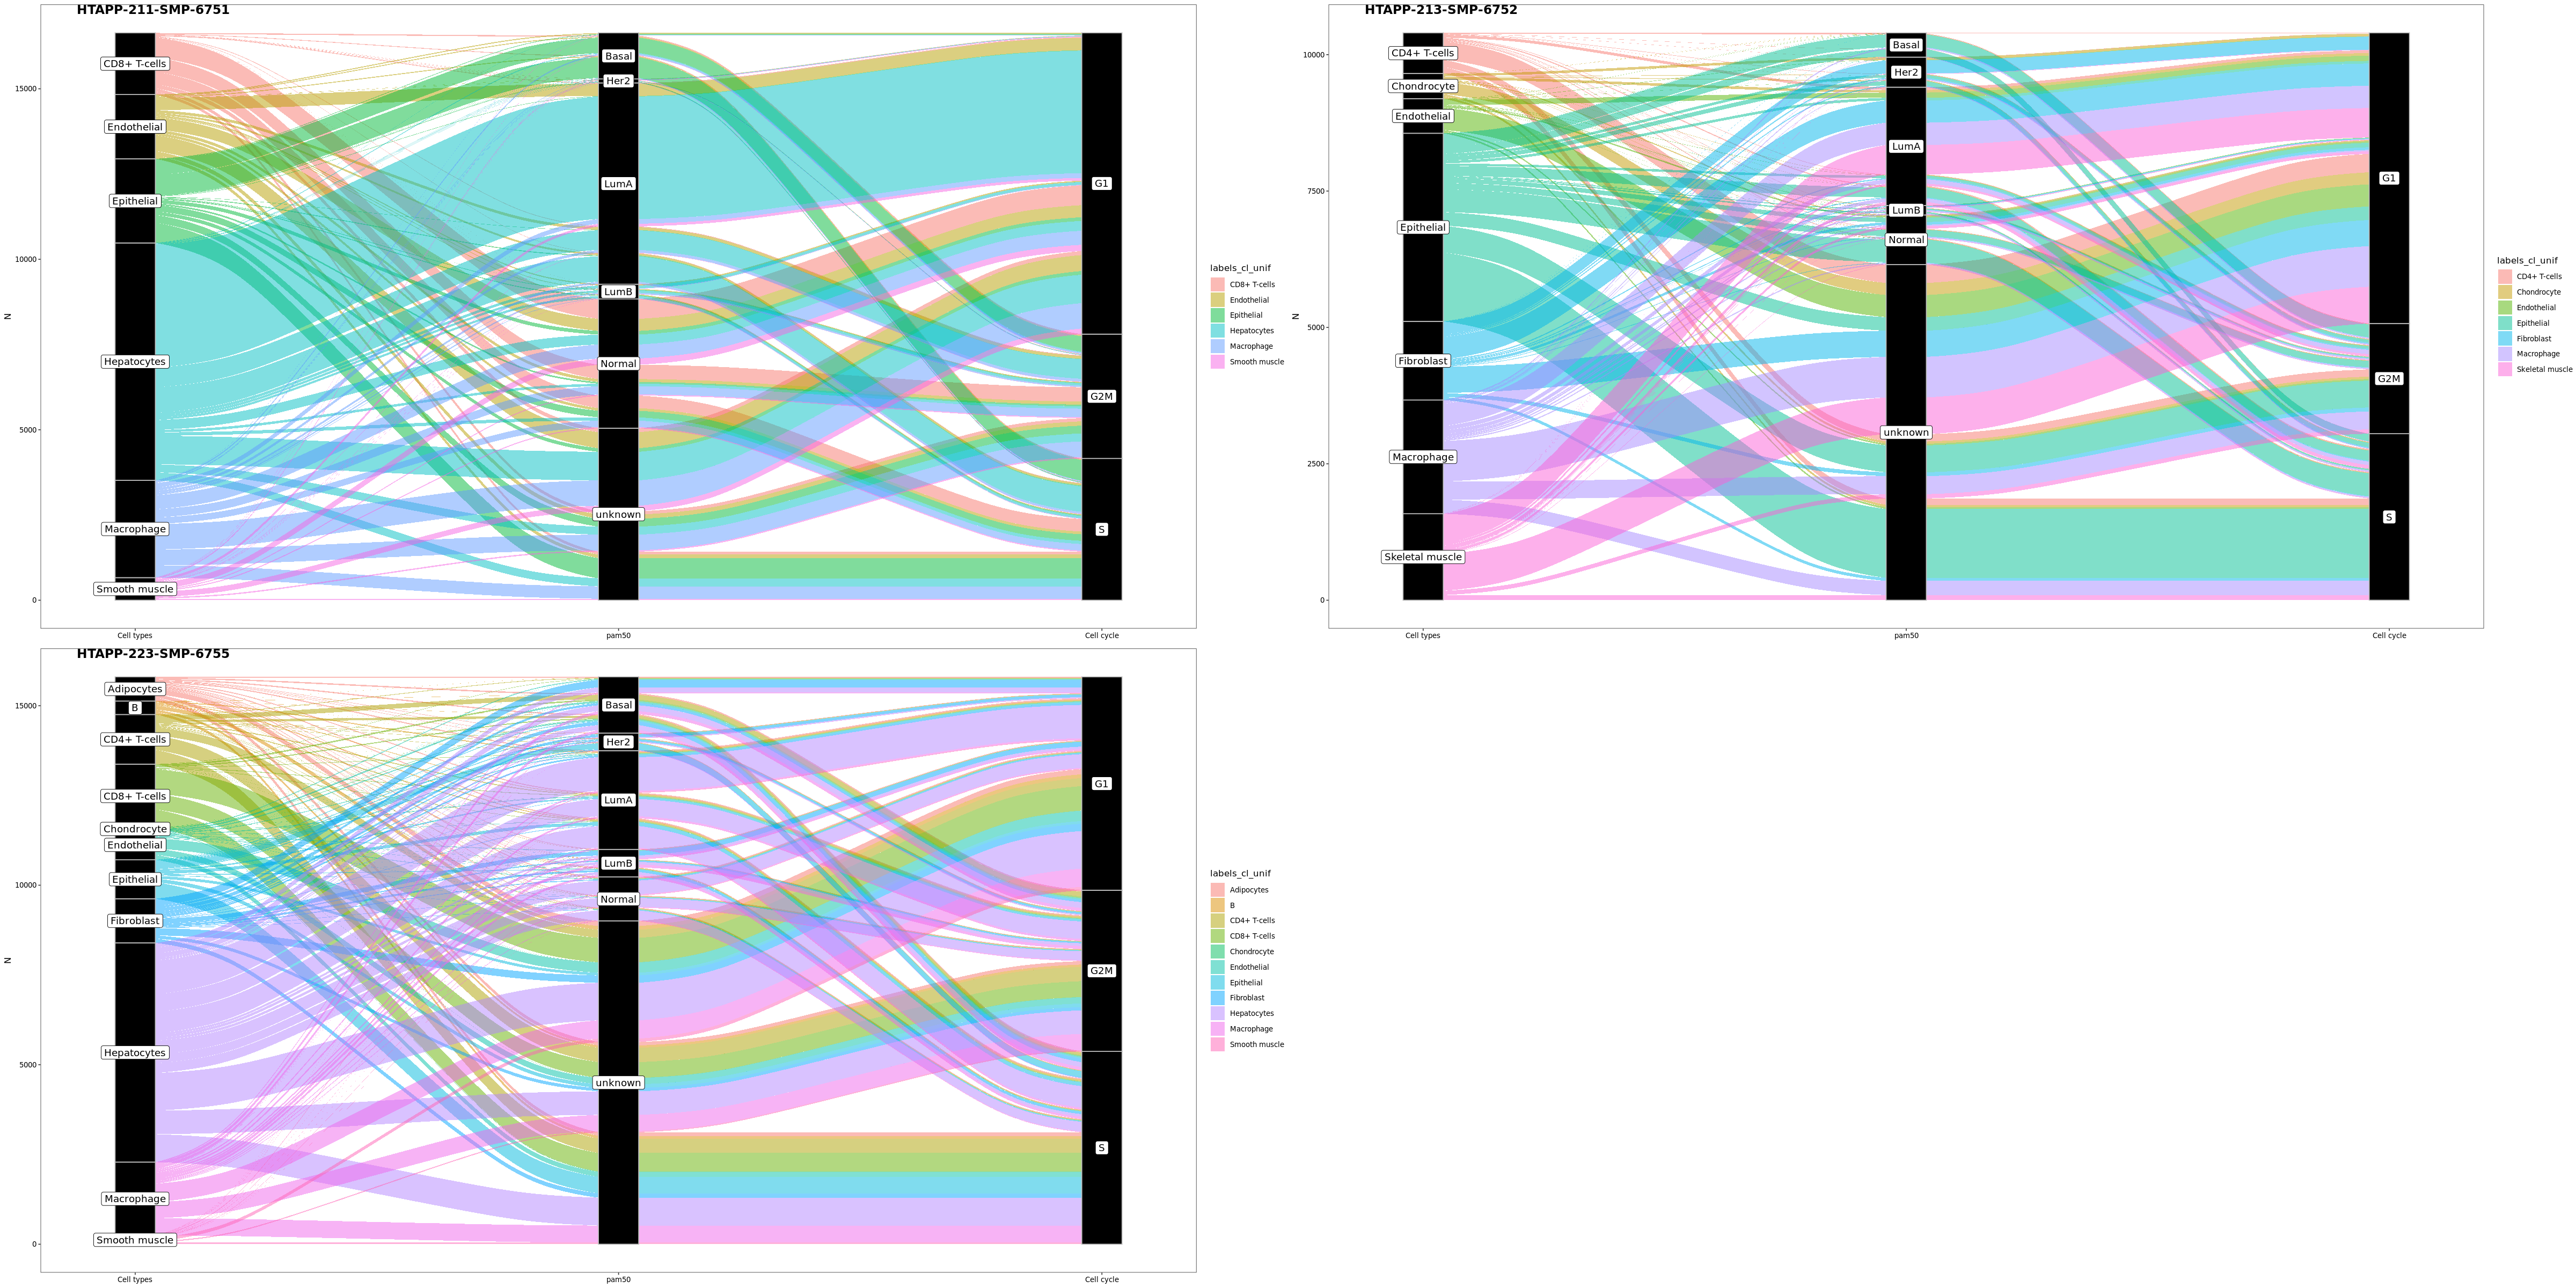

In [19]:
options(repr.plot.width = 40, repr.plot.height =20)
cowplot::plot_grid(plotlist = pl_alluvial,labels = names(pl_alluvial))

In [253]:
#functions for pseudobulk
get_profile=function(x){
    p=apply(dat[as.character(x), ], 2, mean)
    p_dt=data.table(genes=names(p),values=p)
    return(p_dt)
}

res2=data.table()
#run loop
for (sample in samples[29:length(samples)]){

    print(sample)
    fp=file.path(out_dir,paste0(sample,"_bulk_subtypes.tsv"))
    
    if (file.exists(fp)){
        print("done!")
        next
    }
    
    simpleCache(cacheName = sample,cacheDir = cacheDir,cacheSubDir = "filtered",assignToVariable = "ss")
    nstart=nrow(ss@meta.data)
    
    #pam50
    dat=t(GetAssayData(ss,slot = "data"))
    colnames(dat)[colnames(dat)=="NUF2"]="CDCA1"
    colnames(dat)[colnames(dat)=="NDC80"]="KNTC2"
    colnames(dat)[colnames(dat)=="ORC6"]="ORC6L"
    
    raw=t(GetAssayData(ss,slot = "counts"))
    colnames(raw)[colnames(raw)=="NUF2"]="CDCA1"
    colnames(raw)[colnames(raw)=="NDC80"]="KNTC2"
    colnames(raw)[colnames(raw)=="ORC6"]="ORC6L"
    gene_annot=data.frame(Gene.Symbol=colnames(dat))
    
    #pseudobulk # with molecular.subtyping weirdly samples seem to be interacting --> results are different depending on what is analyzed togetehr
    bulk=as.data.frame(cbind(apply(dat, 2, mean),
                               apply(raw, 2, sum),
                               log(apply(raw, 2, sum)+1),
                               apply(raw[,ss@meta.data$labels_cl_unif%in%c("Epithelial","Mesangial cells","Embryonic_stem_cells","iPS_cells","Neurons")], 2, sum)))

    if (ncol(bulk)==3){
        bulk$V4=NA
    }
   # mst_cl=molecular.subtyping(sbt.model="pam50",data=bulk,annot = gene_annot)
    #use correlations instead
    pam=pam50$centroids
    merged=merge(pam,bulk,by='row.names')
    c=cor(merged[,-c(1)],method = "spearman")

    
    
    #p=as.data.table(mst_cl$subtype.proba)
    p=as.data.table(c[c("V1","V2","V3","V4"),c("Basal","Her2","LumA","LumB","Normal")])
    p$sample=sample
    p$type=c("norm","raw","log_raw","mal")
    res2=rbindlist(list(res2,p))
    
}

[1] "HTAPP-586-SMP-8599"


::Loading cache::	/scratch/projects/HTAPP_MBC//phase2/RCache//filtered/HTAPP-586-SMP-8599.RData


[1] "HTAPP-589-SMP-2851"


::Loading cache::	/scratch/projects/HTAPP_MBC//phase2/RCache//filtered/HTAPP-589-SMP-2851.RData


[1] "HTAPP-589-SMP-2860"


::Loading cache::	/scratch/projects/HTAPP_MBC//phase2/RCache//filtered/HTAPP-589-SMP-2860.RData


[1] "HTAPP-600-SMP-2941"


::Loading cache::	/scratch/projects/HTAPP_MBC//phase2/RCache//filtered/HTAPP-600-SMP-2941.RData


[1] "HTAPP-611-SMP-3062"


::Loading cache::	/scratch/projects/HTAPP_MBC//phase2/RCache//filtered/HTAPP-611-SMP-3062.RData


[1] "HTAPP-627-SMP-3242"


::Loading cache::	/scratch/projects/HTAPP_MBC//phase2/RCache//filtered/HTAPP-627-SMP-3242.RData


[1] "HTAPP-649-SMP-3422"


::Loading cache::	/scratch/projects/HTAPP_MBC//phase2/RCache//filtered/HTAPP-649-SMP-3422.RData


[1] "HTAPP-662-SMP-3602"


::Loading cache::	/scratch/projects/HTAPP_MBC//phase2/RCache//filtered/HTAPP-662-SMP-3602.RData


[1] "HTAPP-735-SMP-3841"


::Loading cache::	/scratch/projects/HTAPP_MBC//phase2/RCache//filtered/HTAPP-735-SMP-3841.RData


[1] "HTAPP-745-SMP-3961"


::Loading cache::	/scratch/projects/HTAPP_MBC//phase2/RCache//filtered/HTAPP-745-SMP-3961.RData


[1] "HTAPP-749-SMP-3991"


::Loading cache::	/scratch/projects/HTAPP_MBC//phase2/RCache//filtered/HTAPP-749-SMP-3991.RData


[1] "HTAPP-752-SMP-4051"


::Loading cache::	/scratch/projects/HTAPP_MBC//phase2/RCache//filtered/HTAPP-752-SMP-4051.RData


[1] "HTAPP-759-SMP-8359"


::Loading cache::	/scratch/projects/HTAPP_MBC//phase2/RCache//filtered/HTAPP-759-SMP-8359.RData


[1] "HTAPP-783-SMP-4081"


::Loading cache::	/scratch/projects/HTAPP_MBC//phase2/RCache//filtered/HTAPP-783-SMP-4081.RData


[1] "HTAPP-806-SMP-6789"


::Loading cache::	/scratch/projects/HTAPP_MBC//phase2/RCache//filtered/HTAPP-806-SMP-6789.RData


[1] "HTAPP-806-SMP-6800"


::Loading cache::	/scratch/projects/HTAPP_MBC//phase2/RCache//filtered/HTAPP-806-SMP-6800.RData


[1] "HTAPP-812-SMP-8239"


::Loading cache::	/scratch/projects/HTAPP_MBC//phase2/RCache//filtered/HTAPP-812-SMP-8239.RData


[1] "HTAPP-814-SMP-6879"


::Loading cache::	/scratch/projects/HTAPP_MBC//phase2/RCache//filtered/HTAPP-814-SMP-6879.RData


[1] "HTAPP-835-SMP-6999"


::Loading cache::	/scratch/projects/HTAPP_MBC//phase2/RCache//filtered/HTAPP-835-SMP-6999.RData


[1] "HTAPP-851-SMP-4351"


::Loading cache::	/scratch/projects/HTAPP_MBC//phase2/RCache//filtered/HTAPP-851-SMP-4351.RData


[1] "HTAPP-853-SMP-4381"


::Loading cache::	/scratch/projects/HTAPP_MBC//phase2/RCache//filtered/HTAPP-853-SMP-4381.RData


[1] "HTAPP-861-SMP-7028"


::Loading cache::	/scratch/projects/HTAPP_MBC//phase2/RCache//filtered/HTAPP-861-SMP-7028.RData


[1] "HTAPP-862-SMP-7059"


::Loading cache::	/scratch/projects/HTAPP_MBC//phase2/RCache//filtered/HTAPP-862-SMP-7059.RData


[1] "HTAPP-862-SMP-7060"


::Loading cache::	/scratch/projects/HTAPP_MBC//phase2/RCache//filtered/HTAPP-862-SMP-7060.RData


[1] "HTAPP-870-SMP-7089"


::Loading cache::	/scratch/projects/HTAPP_MBC//phase2/RCache//filtered/HTAPP-870-SMP-7089.RData


[1] "HTAPP-873-SMP-7119"


::Loading cache::	/scratch/projects/HTAPP_MBC//phase2/RCache//filtered/HTAPP-873-SMP-7119.RData


[1] "HTAPP-878-SMP-7149"


::Loading cache::	/scratch/projects/HTAPP_MBC//phase2/RCache//filtered/HTAPP-878-SMP-7149.RData


[1] "HTAPP-880-SMP-7179"


::Loading cache::	/scratch/projects/HTAPP_MBC//phase2/RCache//filtered/HTAPP-880-SMP-7179.RData


[1] "HTAPP-887-SMP-7239"


::Loading cache::	/scratch/projects/HTAPP_MBC//phase2/RCache//filtered/HTAPP-887-SMP-7239.RData


[1] "HTAPP-887-SMP-7250"


::Loading cache::	/scratch/projects/HTAPP_MBC//phase2/RCache//filtered/HTAPP-887-SMP-7250.RData


[1] "HTAPP-889-SMP-7269"


::Loading cache::	/scratch/projects/HTAPP_MBC//phase2/RCache//filtered/HTAPP-889-SMP-7269.RData


[1] "HTAPP-889-SMP-7270"


::Loading cache::	/scratch/projects/HTAPP_MBC//phase2/RCache//filtered/HTAPP-889-SMP-7270.RData


[1] "HTAPP-890-SMP-7299"


::Loading cache::	/scratch/projects/HTAPP_MBC//phase2/RCache//filtered/HTAPP-890-SMP-7299.RData


[1] "HTAPP-895-SMP-7359"


::Loading cache::	/scratch/projects/HTAPP_MBC//phase2/RCache//filtered/HTAPP-895-SMP-7359.RData


[1] "HTAPP-908-SMP-4412"


::Loading cache::	/scratch/projects/HTAPP_MBC//phase2/RCache//filtered/HTAPP-908-SMP-4412.RData


[1] "HTAPP-917-SMP-4531"


::Loading cache::	/scratch/projects/HTAPP_MBC//phase2/RCache//filtered/HTAPP-917-SMP-4531.RData


[1] "HTAPP-944-SMP-7479"


::Loading cache::	/scratch/projects/HTAPP_MBC//phase2/RCache//filtered/HTAPP-944-SMP-7479.RData


[1] "HTAPP-947-SMP-7509"


::Loading cache::	/scratch/projects/HTAPP_MBC//phase2/RCache//filtered/HTAPP-947-SMP-7509.RData


[1] "HTAPP-963-SMP-4741"


::Loading cache::	/scratch/projects/HTAPP_MBC//phase2/RCache//filtered/HTAPP-963-SMP-4741.RData


[1] "HTAPP-982-SMP-7629"


::Loading cache::	/scratch/projects/HTAPP_MBC//phase2/RCache//filtered/HTAPP-982-SMP-7629.RData


[1] "HTAPP-983-SMP-7659"


::Loading cache::	/scratch/projects/HTAPP_MBC//phase2/RCache//filtered/HTAPP-983-SMP-7659.RData


[1] "HTAPP-988-SMP-7749"


::Loading cache::	/scratch/projects/HTAPP_MBC//phase2/RCache//filtered/HTAPP-988-SMP-7749.RData


[1] "HTAPP-997-SMP-7789"


::Loading cache::	/scratch/projects/HTAPP_MBC//phase2/RCache//filtered/HTAPP-997-SMP-7789.RData


In [254]:
res_prob=melt(res2,id.vars = c("sample","type"))

In [255]:
res_prob[,value_0:=ifelse(value<0,0,value),]
res_prob[,prob:=value_0/sum(value_0),by=c("sample","type")]
head(res_prob)

sample             type    variable value       value_0 prob
1 HTAPP-211-SMP-6751 norm    Basal    -0.31419969 0       0   
2 HTAPP-211-SMP-6751 raw     Basal    -0.28987487 0       0   
3 HTAPP-211-SMP-6751 log_raw Basal    -0.28080358 0       0   
4 HTAPP-211-SMP-6751 mal     Basal    -0.09774730 0       0   
5 HTAPP-213-SMP-6752 norm    Basal    -0.11604403 0       0   
6 HTAPP-213-SMP-6752 raw     Basal    -0.04260097 0       0

In [257]:
res_prob[,source:="sc"]

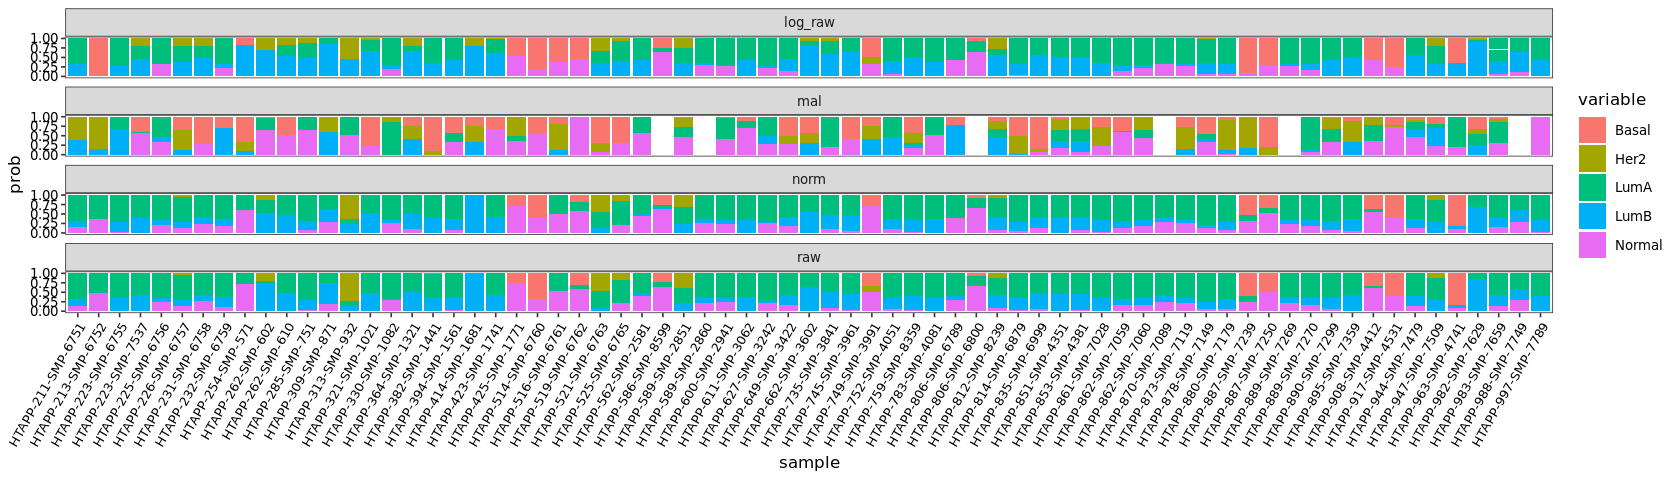

In [256]:
options(repr.plot.width = 14, repr.plot.height =4)
ggplot(res_prob, aes(x=sample,y=prob,fill=variable))+geom_bar(stat="identity",position="stack")+rotate_labels()+facet_wrap(~type,ncol=1)

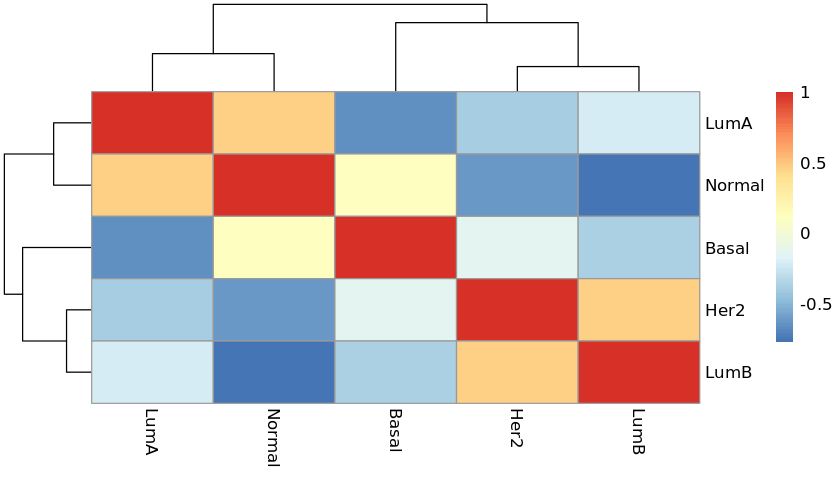

In [274]:
pheatmap(cor(pam50$centroids,method="spearman"))

In [205]:
library(readxl)

In [206]:
bulk=as.data.table(read_xlsx(paste0(metaDir,"/bulk pam50.xlsx")))

In [207]:
bulk=bulk[htapp_id!="NA"&PAM50.subtype!="NA"]

In [208]:
bulk[,sample:=paste0(htapp_id,"-",htapp_caseid)]

In [226]:
bulk_long=melt(bulk[,c("sample","Pr_Basal","Pr_Her2","Pr_LumA","Pr_LumB","Pr_Normal")],id.vars = "sample",value.name = "prob")

In [227]:
bulk_long[,variable:=sub("Pr_","",variable)]

In [228]:
head(bulk_long)

sample             variable prob    
1 HTAPP-225-SMP-6756 Basal    0.000000
2 HTAPP-589-SMP-2860 Basal    0.000000
3 HTAPP-589-SMP-2851 Basal    0.000000
4 HTAPP-231-SMP-6758 Basal    0.292789
5 HTAPP-862-SMP-7059 Basal    0.000000
6 HTAPP-862-SMP-7060 Basal    0.000000

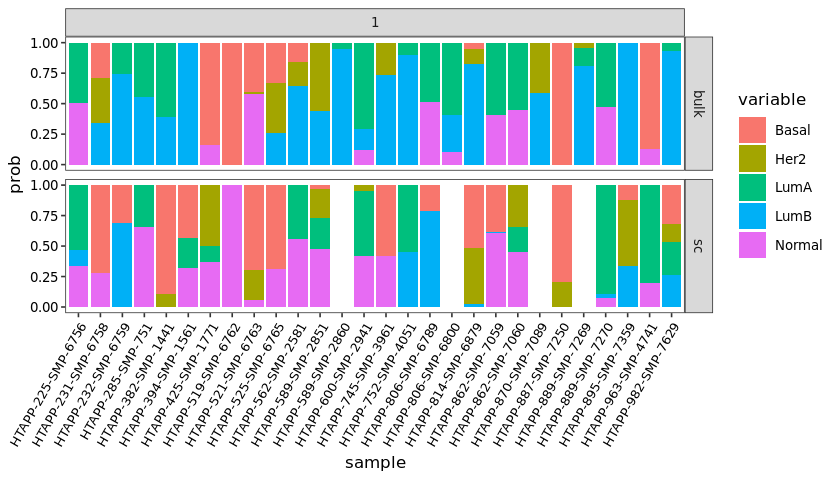

In [265]:
options(repr.plot.width = 7, repr.plot.height =4)
both_mal=rbindlist(list(res_prob[sample%in%bulk_long$sample&type=="mal"],bulk_long[,source:="bulk"]),fill=T)
ggplot(both_mal, aes(x=sample,y=prob,fill=variable))+geom_bar(stat="identity",position="stack")+rotate_labels()+facet_grid(source~1)

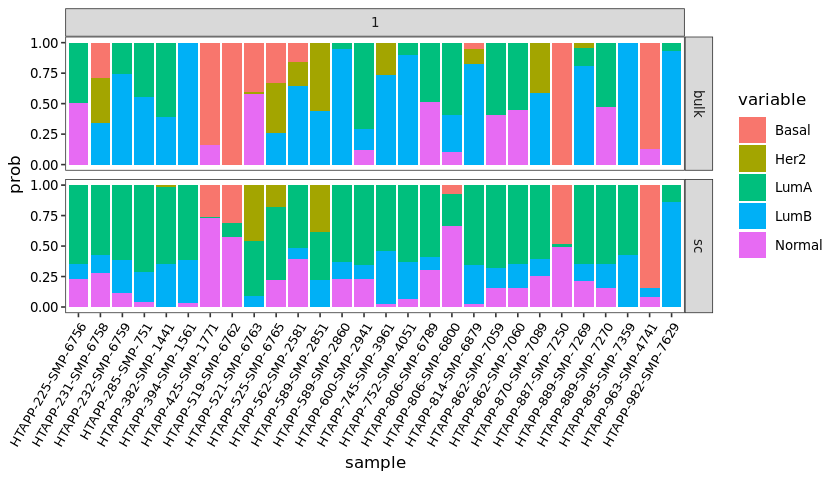

In [268]:
options(repr.plot.width = 7, repr.plot.height =4)
both_raw=rbindlist(list(res_prob[sample%in%bulk_long$sample&type=="raw"],bulk_long[,source:="bulk"]),fill=T)
ggplot(both_raw, aes(x=sample,y=prob,fill=variable))+geom_bar(stat="identity",position="stack")+rotate_labels()+facet_grid(source~1)

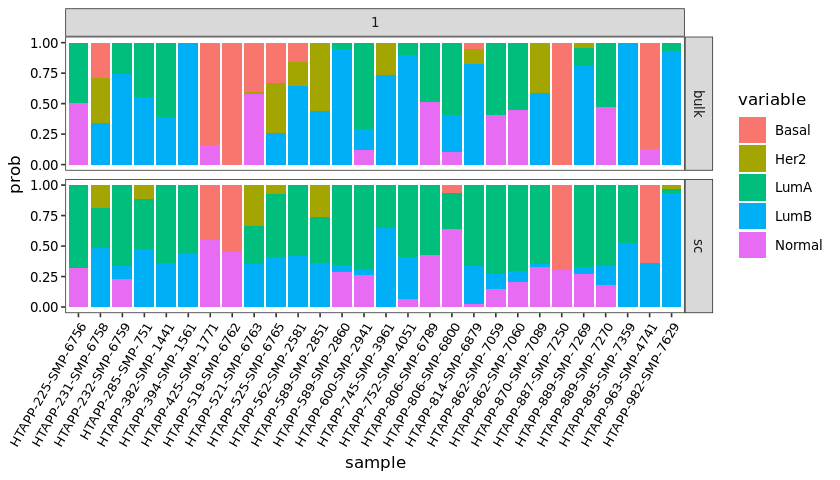

In [270]:
options(repr.plot.width = 7, repr.plot.height =4)
both_lraw=rbindlist(list(res_prob[sample%in%bulk_long$sample&type=="log_raw"],bulk_long[,source:="bulk"]),fill=T)
ggplot(both_lraw, aes(x=sample,y=prob,fill=variable))+geom_bar(stat="identity",position="stack")+rotate_labels()+facet_grid(source~1)

# CLIF
# HONDA